# Install Some Packages

In [53]:
# Install some packages
!pip install rasterio
!pip install earthpy
!pip install tensorflow

# Import Packages

In [56]:
import pandas as pd
import numpy as np
import rasterio
import earthpy.plot as ep
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
from matplotlib.colors import from_levels_and_colors
from tensorflow.keras.layers import Dense, Input, Flatten, Conv1D, Conv1DTranspose, Reshape
from tensorflow.keras.models import Model
import numpy as np
from tensorflow.keras import backend as K
from tensorflow.keras import Model
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf

# Mount Google Drive

In [34]:
#Only run this code if you use Google Colab
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

# Parameter

In [57]:
FEATURES = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'EVI', 'NBR', 'NDMI', 'NDWI', 'NDBI', 'NDBaI', 'elevation']
LABEL = ['classvalue']
SPLIT = ['sample']
N_CLASSES = 6
CLASSES = [1, 2, 3, 4, 5, 6]
PALETTE = ['#F08080', '#D2B48C', '#87CEFA', '#008080', '#90EE90', '#228B22']

In [58]:
#if you execute in local run this code
SAMPLE_PATH = 'Samples_Primavera.csv'
IMAGE_PATH = 'Primavera.tif'

In [ ]:
#if you execute in Google Colab run this code
SAMPLE_PATH = '/content/drive/MyDrive/deep/Samples_Primavera.csv'
IMAGE_PATH = '/content/drive/MyDrive/deep/Primavera.tif'

# Load image

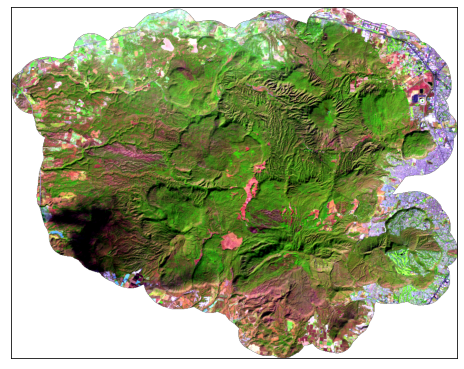

<AxesSubplot:>

In [59]:
image = rasterio.open(IMAGE_PATH)
bandNum = image.count
height = image.height
width = image.width
crs = image.crs
transform = image.transform
shape = (height, width)

image_vis = []
for x in [6, 5, 4]:
  image_vis.append(image.read(x))
image_vis = np.stack(image_vis)

plot_size = (8, 8)
ep.plot_rgb(
  image_vis,
  figsize=plot_size,
  stretch=True,
)

# Read sample

In [60]:
samples = pd.read_csv(SAMPLE_PATH)
samples = samples.sample(frac = 1) # Shuffle data
samples

,B1,B2,B3,B4,B5,B6,B7,EVI,NBR,NDMI,NDWI,NDBI,NDBaI,elevation,classvalue,sample
2972,0.037738,0.041285,0.061277,0.064990,0.203398,0.185248,0.123922,0.269548,0.242805,0.046701,-0.536960,-0.046701,0.198354,1780,1,test
6482,0.035620,0.047418,0.074285,0.090510,0.228670,0.242640,0.163055,0.243910,0.167503,-0.029641,-0.509597,0.029641,0.196170,1574,5,train
5921,0.045300,0.065842,0.102803,0.105855,0.219567,0.188383,0.150212,0.208895,0.187557,0.076443,-0.362208,-0.076443,0.112731,1676,3,test
5483,0.087678,0.114765,0.146445,0.196935,0.243712,0.283367,0.223417,0.074744,0.043446,-0.075235,-0.249303,0.075235,0.118295,1719,3,test
2072,0.040240,0.048352,0.068400,0.076430,0.198777,0.214590,0.142127,0.236244,0.166175,-0.038253,-0.487981,0.038253,0.203137,1737,1,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5235,0.087045,0.108963,0.150295,0.183240,0.245362,0.269095,0.216075,0.101668,0.063470,-0.046131,-0.240277,0.046131,0.109281,1725,3,test
3806,0.057647,0.084735,0.141192,0.155492,0.269232,0.238790,0.197430,0.181499,0.153864,0.059924,-0.311969,-0.059924,0.094815,1620,3,train
1009,0.024015,0.032567,0.057812,0.052038,0.264200,0.171882,0.096010,0.398152,0.466922,0.211697,-0.640930,-0.211697,0.283220,1603,1,train
2568,0.027700,0.032622,0.046922,0.053330,0.130385,0.150817,0.112180,0.159773,0.075052,-0.072661,-0.470722,0.072661,0.146912,1788,1,train


# Split into train and test based on column

In [61]:
train = samples[samples['sample'] == 'train']
test = samples[samples['sample'] == 'test']

# Split between features and label

In [62]:
train_features = train[FEATURES]
train_label = train[LABEL]
test_features = test[FEATURES]
test_label = test[LABEL]

# Function to reshape array input

In [63]:
def reshape_input(array):
  shape = array.shape
  return array.reshape(shape[0], shape[1], 1)

# Convert samples dataframe (pandas) to numpy array

In [65]:
train_input = reshape_input(train_features.to_numpy())
test_input = reshape_input(test_features.to_numpy())

# Also make label data to categorical

In [66]:
train_output = to_categorical(train_label.to_numpy(), N_CLASSES + 1, int)
test_output = to_categorical(test_label.to_numpy(), N_CLASSES + 1, int)

# Show the data shape


In [67]:
print(f'Train features: {train_input.shape}\nTest features: {test_input.shape}\nTrain label: {train_output.shape}\nTest label: {test_output.shape}')

Train features: (4968, 14, 1)
Test features: (2714, 14, 1)
Train label: (4968, 7)
Test label: (2714, 7)


# Make AutoEncoder

In [68]:
latent_dim = N_CLASSES + 1

# Input shape

In [69]:
train_shape = train_input.shape
input_shape = (train_shape[1], train_shape[2])


# Conv1D flat

In [70]:
inputs = Input(shape = input_shape, name = "clasificator_input")

In [154]:
x = Conv1D(7, 3, activation = "relu", strides = 2, padding = "same")(inputs)
x = Conv1D(14, 2, activation = "relu", strides = 7, padding = "same")(x)

shape_before_flat = K.int_shape(x)

x = Flatten()(x)
x = Dense(64, activation = "relu" )(x)
encoded = Dense(latent_dim, activation = 'softmax')(x)

In [155]:
shape_before_flat

(None, 1, 14)

# Encoder

In [156]:
encoder = Model(inputs, encoded, name='encoder')
encoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 clasificator_input (InputLa  [(None, 14, 1)]          0         
 yer)                                                            
                                                                 
 conv1d_39 (Conv1D)          (None, 7, 7)              28        
                                                                 
 conv1d_40 (Conv1D)          (None, 1, 14)             210       
                                                                 
 flatten_9 (Flatten)         (None, 14)                0         
                                                                 
 dense_53 (Dense)            (None, 64)                960       
                                                                 
 dense_54 (Dense)            (None, 7)                 455       
                                                           

# Decoder

In [157]:
shape_before_flat

(None, 1, 14)

In [158]:
latent_inputs = Input(shape=(latent_dim,), name='latent')

In [161]:
x = Dense(np.prod(shape_before_flat[1:]), activation = "relu")(latent_inputs)
x = Reshape(shape_before_flat[1:])(x)
x = Conv1DTranspose(14, 3, activation = "relu", strides =  7, padding= "same")(x)
x = Conv1DTranspose(7, 3, activation = "relu", strides = 2, padding = "same")(x)
outputs = Conv1DTranspose(1, 2, activation = "sigmoid", padding = "same")(x)

In [162]:
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 latent (InputLayer)         [(None, 7)]               0         
                                                                 
 dense_56 (Dense)            (None, 14)                112       
                                                                 
 reshape_27 (Reshape)        (None, 1, 14)             0         
                                                                 
 conv1d_transpose_147 (Conv1  (None, 7, 14)            602       
 DTranspose)                                                     
                                                                 
 conv1d_transpose_148 (Conv1  (None, 14, 7)            301       
 DTranspose)                                                     
                                                                 
 conv1d_transpose_149 (Conv1  (None, 14, 1)            15  

# Autoencoder

In [163]:
outputs = decoder(encoder(inputs))
ae = Model(inputs, outputs, name='ae')
ae.summary()

Model: "ae"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 clasificator_input (InputLa  [(None, 14, 1)]          0         
 yer)                                                            
                                                                 
 encoder (Functional)        (None, 7)                 1653      
                                                                 
 decoder (Functional)        (None, 14, 1)             1030      
                                                                 
Total params: 2,683
Trainable params: 2,683
Non-trainable params: 0
_________________________________________________________________


# Train the autoencoder

# Compline the model

In [164]:
ae.compile(
    optimizer='Adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Fit the model

In [165]:
print(train_input.shape)
print(test_input.shape)

(4968, 14, 1)
(2714, 14, 1)


In [166]:
ae.fit(
    train_input,
    train_input,
    epochs = 5,
    validation_data = (test_input, test_input)
)

Epoch 1/5
156/156 [==============================] - 2s 6ms/step - loss: -13.6830 - accuracy: 0.0000e+00 - val_loss: -49.0562 - val_accuracy: 2.6319e-05
Epoch 2/5
156/156 [==============================] - 1s 4ms/step - loss: -192.3205 - accuracy: 0.0000e+00 - val_loss: -460.6744 - val_accuracy: 2.6319e-05
Epoch 3/5
156/156 [==============================] - 1s 3ms/step - loss: -962.3340 - accuracy: 0.0000e+00 - val_loss: -1731.9136 - val_accuracy: 2.6319e-05
Epoch 4/5
156/156 [==============================] - 0s 3ms/step - loss: -2744.0891 - accuracy: 0.0000e+00 - val_loss: -4233.7529 - val_accuracy: 2.6319e-05
Epoch 5/5
156/156 [==============================] - 0s 3ms/step - loss: -5857.8276 - accuracy: 0.0000e+00 - val_loss: -8266.6416 - val_accuracy: 2.6319e-05


In [169]:
encoded_test = encoder.predict(test_input)
encoded_test.shape

(2714, 7)

In [172]:
generate_test = decoder.predict(encoded_input)
generate_test.shape

(2714, 14, 1)

# Make model for our data

In [173]:
inputs = Input(shape = input_shape, name = "clasificator_input")

In [174]:
x = Conv1D(64, 2, activation = "relu")(inputs)
x = Conv1D(64, 2, activation = "relu", strides = 2, padding = "same")(x)
x = Conv1D(128, 2, activation = "relu")(x)
x = Conv1D(128, 2, activation = "relu", strides = 3, padding = "same")(x)
x = Conv1D(128, 2, activation = "relu", strides = 2, padding = "same")(x)
x = Flatten()(x)
x = Dense(128, activation = "relu" )(x)
x = Dense(64, activation = "relu" )(x)
clasificate = Dense(N_CLASSES + 1, activation = 'softmax')(x)

clasificator = Model(inputs, clasificate, name='clasificator')
clasificator.summary()

Model: "clasificator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 clasificator_input (InputLa  [(None, 14, 1)]          0         
 yer)                                                            
                                                                 
 conv1d_41 (Conv1D)          (None, 13, 64)            192       
                                                                 
 conv1d_42 (Conv1D)          (None, 7, 64)             8256      
                                                                 
 conv1d_43 (Conv1D)          (None, 6, 128)            16512     
                                                                 
 conv1d_44 (Conv1D)          (None, 2, 128)            32896     
                                                                 
 conv1d_45 (Conv1D)          (None, 1, 128)            32896     
                                                      

In [175]:
outputs = clasificator(inputs)
model = Model(inputs, outputs, name='clasificator')

# Train the model

# Compline the model

In [176]:
model.compile(
    optimizer='Adam',
    loss='CategoricalCrossentropy',
    metrics=['accuracy']
)

# Create callback to stop training if loss not decreasing

In [177]:
stop = EarlyStopping(
    monitor='loss',
    patience=5
)

# Fit the model

In [179]:
result = model.fit(
    x=train_input, y=train_output,
    validation_data=(generate_test, test_output),
    batch_size=1024,
    callbacks=[stop],
    epochs=100,
)

Epoch 1/100
5/5 [==============================] - 1s 88ms/step - loss: 1.9286 - accuracy: 0.4684 - val_loss: 1.9487 - val_accuracy: 0.1909
Epoch 2/100
5/5 [==============================] - 0s 37ms/step - loss: 1.8197 - accuracy: 0.5177 - val_loss: 1.9621 - val_accuracy: 0.1909
Epoch 3/100
5/5 [==============================] - 0s 36ms/step - loss: 1.5267 - accuracy: 0.5177 - val_loss: 3.1917 - val_accuracy: 0.1909
Epoch 4/100
5/5 [==============================] - 0s 34ms/step - loss: 1.4320 - accuracy: 0.5177 - val_loss: 2.1905 - val_accuracy: 0.1909
Epoch 5/100
5/5 [==============================] - 0s 34ms/step - loss: 1.3469 - accuracy: 0.5177 - val_loss: 2.1919 - val_accuracy: 0.1909
Epoch 6/100
5/5 [==============================] - 0s 37ms/step - loss: 1.2556 - accuracy: 0.5177 - val_loss: 2.8514 - val_accuracy: 0.1909
Epoch 7/100
5/5 [==============================] - 0s 65ms/step - loss: 1.1623 - accuracy: 0.5342 - val_loss: 3.0792 - val_accuracy: 0.1909
Epoch 8/100
5/5 [===

# Show history

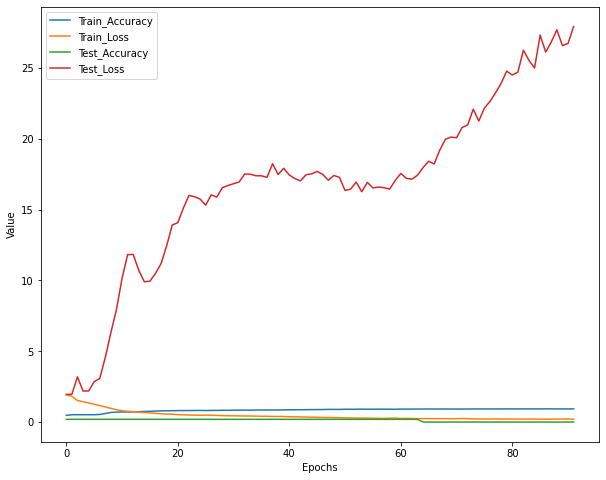

In [180]:
history = pd.DataFrame(result.history)

plt.figure(figsize = (10, 8))
plt.plot(range(len(history['accuracy'].values.tolist())), history['accuracy'].values.tolist(), label = 'Train_Accuracy')
plt.plot(range(len(history['loss'].values.tolist())), history['loss'].values.tolist(), label = 'Train_Loss')
plt.plot(range(len(history['val_accuracy'].values.tolist())), history['val_accuracy'].values.tolist(), label = 'Test_Accuracy')
plt.plot(range(len(history['val_loss'].values.tolist())), history['val_loss'].values.tolist(), label = 'Test_Loss')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.legend()
plt.show()

# Predict test data

In [181]:
prediction = np.argmax(model.predict(test_input), 1).flatten()
label = np.argmax(test_output, 1).flatten()

# Confusion matrix

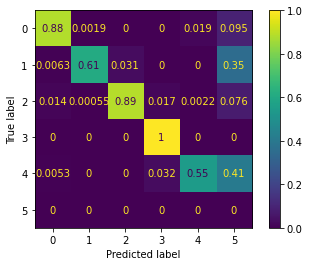

In [182]:
cm = confusion_matrix(label, prediction, normalize='true')
cm = ConfusionMatrixDisplay(cm)
cm.plot()


# Classification report

In [183]:
print(classification_report(label, prediction))

              precision    recall  f1-score   support

           1       0.94      0.88      0.91       518
           2       0.98      0.61      0.75       159
           3       1.00      0.89      0.94      1815
           4       0.47      1.00      0.64        33
           5       0.88      0.55      0.68       189
           6       0.00      0.00      0.00         0

    accuracy                           0.85      2714
   macro avg       0.71      0.66      0.65      2714
weighted avg       0.97      0.85      0.90      2714



c:\Users\Cesar\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Cesar\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Cesar\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Predict image using the model

In [184]:
image_input = []
for x in range(14):
  image_input.append(image.read(x + 1))
image_input = reshape_input(np.stack(image_input).reshape(14, -1).T)

# Predict

In [185]:
prediction = model.predict(image_input, batch_size=4096*20)
prediction = np.argmax(prediction, 1)
prediction = prediction.reshape(shape[0], shape[1])

# Visualize

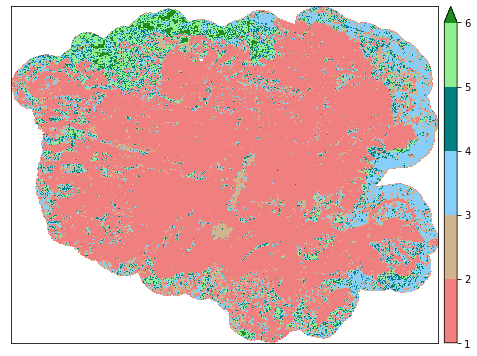

<AxesSubplot:>

In [186]:
cmap, norm = from_levels_and_colors(CLASSES, PALETTE, extend='max')
ep.plot_bands(prediction, cmap=cmap, norm=norm, figsize=plot_size)

# Save file in local

In [187]:
#if you execute in local run this code
name = 'deepPrimavera.tif'
location = name

# Save file in Google Drive

In [ ]:
#Only run this code if you use Google Colab
save_location = '/content/drive/MyDrive/Deep/'
name = 'deepPrimavera.tif'
location = save_location + name

In [188]:
new_dataset = rasterio.open(
      location,
      mode='w', driver='GTiff',
      height = prediction.shape[0], width = prediction.shape[1],
      count=1, dtype=str(prediction.dtype),
      crs=crs,
      transform=transform
)
new_dataset.write(prediction, 1);
new_dataset.close()